In [10]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider
from scipy.stats import pearsonr
from ipywidgets import interact, IntSlider, fixed

In [11]:
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent

In [12]:
from network_utils1 import (
    gaussian, create3Dplot, create2Dplot, show_slice,
    plot_all_sensory_fields, plot_sensory_input_subplots,
    plot_initial_activation, plot_normalised_sensory_grid,
    plot_final_activation, generate_evenly_spaced_centers,
    generate_circular_trajectory, generate_edge_to_edge_trajectory,
    plot_trajectory_over_PC_idx, plot_trajectory_over_PC_idx, view_bump_with_slider_3D, 
    show_bump_3D, plot_maze_over_PC_idx) 

In [13]:
# Step 1: Initialise network parameters and matrices

# Grid and network dimensions
rows = 10
cols = 10
nCells = rows * cols

# Sensory and recurrent configuration
nSensoryCells = 50
Sigma = 1.5                 # Spread of the Gaussian tuning curve
NetThreshold = 0.7       # Threshold for activation
nIterationsPerTimestep = 50  # Recurrent iterations per timestep
blend_factor = 0.9          # Influence of new input vs. previous state

# Allocate memory for the recurrent weight matrix
weightsMat = np.zeros((rows, cols, nCells))

# Create an index grid for place cells
PC_idx = np.arange(nCells).reshape(rows, cols)

In [14]:
# Define environment
env = Environment()

# Generate trajectory function
def generate_trajectory(seed=None, T=600.0, dt=0.1):
    if seed is not None:
        np.random.seed(seed)  # Optional for reproducibility
    
    agent = Agent(env)
    agent.speed_mean = 0.08
    agent.speed_coherence_time = 0.7
    agent.rotation_velocity_std = 120 * np.pi / 180
    agent.rotational_velocity_coherence_time = 0.08

    for _ in range(int(T / dt)):
        agent.update(dt=dt)

    positions = np.array(agent.history["pos"]) * 10  # scale to grid
    return positions

# Generate trajectories
positions = generate_trajectory(seed=1)
# positions_B = generate_trajectory(seed=42)

# Print summary
T = 600.0
print(f"Trajectory : {np.unique(positions, axis=0).shape[0]} unique positions (T = {T}s)")
# print(f"Trajectory B: {np.unique(positions_B, axis=0).shape[0]} unique positions (T = {T}s)")

Trajectory : 6000 unique positions (T = 600.0s)


In [15]:
def plot_all_ratemaps(ratemaps, title):
    """
    Plots all place cell ratemaps in a grid with colour heatmaps.
    
    Args:
        ratemaps: np.array of shape (nCells, rows, cols)
        title: str, title for the entire figure
    """
    nCells, rows, cols = ratemaps.shape
    nCols = 10
    nRows = nCells // nCols

    fig, axs = plt.subplots(nRows, nCols, figsize=(15, 15))
    for k in range(nCells):
        ax = axs[k // nCols, k % nCols]
        im = ax.imshow(np.flip(ratemaps[k], axis=0), cmap='viridis', origin='lower')
        ax.set_title(f"PC {k}", fontsize=6)
        ax.axis('off')

    plt.tight_layout()
    fig.subplots_adjust(top=0.95)
    fig.suptitle(title, fontsize=14)
    plt.colorbar(im, ax=axs, orientation='vertical', fraction=0.02)
    plt.show()

In [16]:
def run_AD_gaussian_noise_pipeline(positions):
    print(f"\n Running pipeline for Trajectory")

    pos_indices = np.clip(positions.astype(int), 0, 9)
    pc_indices = [PC_idx[y, x] for x, y in pos_indices]

    # Initialise weightsMat
    weightsMat = np.zeros((rows, cols, nCells))
    pc_coords = []
    for k in range(nCells):
        r, c = np.where(PC_idx == k)
        r, c = r[0], c[0]
        pc_coords.append((r, c))
        weightsMat[r, c, k] = 1.0
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < rows and 0 <= nc < cols:
                weightsMat[nr, nc, k] = 0.5

    # Sensory firing fields
    SensoryFiringFields = np.zeros((rows, cols, nSensoryCells))
    centers = generate_evenly_spaced_centers(rows, cols, nSensoryCells)
    X, Y = np.meshgrid(np.arange(rows), np.arange(cols))
    for i, (cx, cy) in enumerate(centers):
        SensoryFiringFields[:, :, i] = gaussian(X, Y, cx, cy, Sigma)

    # Sensory weights
    sensoryWeights = np.zeros((nSensoryCells, nCells))
    for cell, (r, c) in enumerate(pc_coords):
        sensoryWeights[:, cell] = SensoryFiringFields[r, c, :]

    # Generate sensory input grids
    sensoryInputGrids = []
    for t, (pcRow, pcCol) in enumerate(pos_indices):
        currentSensoryActivity = SensoryFiringFields[pcRow, pcCol, :]
        currentSensoryActivity = np.transpose([currentSensoryActivity])
        currentSensoryActivity = np.matlib.repmat(currentSensoryActivity, 1, nCells)
        sensoryInput = currentSensoryActivity * sensoryWeights
        sensoryInput = np.sum(sensoryInput, axis=0) * 40
        sensoryInputGrid = sensoryInput.reshape(rows, cols)
        sensoryInputGridNormalised = sensoryInputGrid / np.max(sensoryInputGrid)
        sensoryInputGrids.append((sensoryInputGridNormalised, pcRow, pcCol, t + 1))

    # Initialise NetAct
    rng = np.random.default_rng(69)
    NetAct = rng.normal(loc=0.0, scale=0.015, size=(rows, cols))
    NetAct = np.clip(NetAct, 0, 1)

    # Main attractor update loop with Gaussian noise injection 
    results = np.zeros((len(sensoryInputGrids), rows, cols))
    for i, (sensoryInputGridNormalised, pcRow, pcCol, timestep) in enumerate(sensoryInputGrids):
        NetAct = blend_factor * sensoryInputGridNormalised + (1 - blend_factor) * NetAct
        for _ in range(nIterationsPerTimestep):
            NetInput = np.zeros((rows, cols))
            for k, (row, col) in enumerate(pc_coords):
                NetInput += weightsMat[:, :, k] * NetAct[row, col]
            NetInput += sensoryInputGridNormalised

            # Inject Gaussian noise with σ=1 clipped between -2 and 2, then clipped to ≥0 ===
            noise = rng.normal(loc=0.0, scale=1.0, size=(rows, cols))
            noise = np.clip(noise, -2, 2)
            noise = np.clip(noise, 0, None)  # clip negative values to zero
            NetInput += noise

            NetInput = NetInput - np.min(NetInput)
            if np.max(NetInput) > 0:
                NetInput = NetInput / np.max(NetInput)
            NetInput = NetInput * (NetInput >= NetThreshold)
            NetAct = NetInput.copy()
        results[i, :, :] = NetAct

    # Ratemap Generation
    ratemaps = np.zeros((nCells, rows, cols))
    for t in range(results.shape[0]):
        NetAct = results[t]
        for k, (r, c) in enumerate(pc_coords):
            gaussian_field = np.exp(-((X - r)**2 + (Y - c)**2) / (2 * Sigma**2))
            ratemaps[k] += NetAct * gaussian_field

    # Normalize each ratemap
    for k in range(nCells):
        max_val = np.max(ratemaps[k])
        if max_val > 0:
            ratemaps[k] /= max_val

    print(f"Completed pipeline for Trajectory")
    return results, ratemaps

In [17]:
def run_AD_cell_deletion_pipeline(positions, cell_deletion_percent=0):
    print(f"\nRunning pipeline for Trajectory with {cell_deletion_percent}% cell deletion")

    pos_indices = np.clip(positions.astype(int), 0, 9)
    pc_indices = [PC_idx[y, x] for x, y in pos_indices]

    # Initialise weightsMat
    weightsMat = np.zeros((rows, cols, nCells))
    pc_coords = []
    for k in range(nCells):
        r, c = np.where(PC_idx == k)
        r, c = r[0], c[0]
        pc_coords.append((r, c))
        weightsMat[r, c, k] = 1.0
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < rows and 0 <= nc < cols:
                weightsMat[nr, nc, k] = 0.5

    # Delete a percentage of attractor cells
    rng = np.random.default_rng(69)
    n_delete = int(nCells * (cell_deletion_percent / 100))
    deleted_cells = rng.choice(nCells, size=n_delete, replace=False)
    deleted_coords = [pc_coords[k] for k in deleted_cells]

    for k in deleted_cells:
        weightsMat[:, :, k] = 0  # Delete its weight projection

    # Sensory firing fields
    SensoryFiringFields = np.zeros((rows, cols, nSensoryCells))
    centers = generate_evenly_spaced_centers(rows, cols, nSensoryCells)
    X, Y = np.meshgrid(np.arange(rows), np.arange(cols))
    for i, (cx, cy) in enumerate(centers):
        SensoryFiringFields[:, :, i] = gaussian(X, Y, cx, cy, Sigma)

    # Sensory weights
    sensoryWeights = np.zeros((nSensoryCells, nCells))
    for cell, (r, c) in enumerate(pc_coords):
        sensoryWeights[:, cell] = SensoryFiringFields[r, c, :]

    # Generate sensory input grids
    sensoryInputGrids = []
    for t, (pcRow, pcCol) in enumerate(pos_indices):
        currentSensoryActivity = SensoryFiringFields[pcRow, pcCol, :]
        currentSensoryActivity = np.transpose([currentSensoryActivity])
        currentSensoryActivity = np.matlib.repmat(currentSensoryActivity, 1, nCells)
        sensoryInput = currentSensoryActivity * sensoryWeights
        sensoryInput = np.sum(sensoryInput, axis=0) * 40
        sensoryInputGrid = sensoryInput.reshape(rows, cols)
        sensoryInputGridNormalised = sensoryInputGrid / np.max(sensoryInputGrid)
        sensoryInputGrids.append((sensoryInputGridNormalised, pcRow, pcCol, t + 1))

    # Initialise NetAct
    NetAct = rng.normal(loc=0.0, scale=0.015, size=(rows, cols))
    NetAct = np.clip(NetAct, 0, 1)

    # Main attractor update loop
    results = np.zeros((len(sensoryInputGrids), rows, cols))
    for i, (sensoryInputGridNormalised, pcRow, pcCol, timestep) in enumerate(sensoryInputGrids):
        NetAct = blend_factor * sensoryInputGridNormalised + (1 - blend_factor) * NetAct

        # Zero out activity of deleted cells each timestep
        for (r, c) in deleted_coords:
            NetAct[r, c] = 0

        for _ in range(nIterationsPerTimestep):
            NetInput = np.zeros((rows, cols))
            for k, (row, col) in enumerate(pc_coords):
                NetInput += weightsMat[:, :, k] * NetAct[row, col]
            NetInput += sensoryInputGridNormalised
            NetInput += rng.normal(loc=0.0, scale=0.01, size=(rows, cols))
            NetInput = NetInput - np.min(NetInput)
            if np.max(NetInput) > 0:
                NetInput = NetInput / np.max(NetInput)
            NetInput = NetInput * (NetInput >= NetThreshold)

            # Zero out deleted cells again after recurrent update
            for (r, c) in deleted_coords:
                NetInput[r, c] = 0

            NetAct = NetInput.copy()
        results[i, :, :] = NetAct

    # Ratemap Generation
    ratemaps = np.zeros((nCells, rows, cols))
    for t in range(results.shape[0]):
        NetAct = results[t]
        for k, (r, c) in enumerate(pc_coords):
            gaussian_field = np.exp(-((X - r)**2 + (Y - c)**2) / (2 * Sigma**2))
            ratemaps[k] += NetAct * gaussian_field

    # Normalize each ratemap
    for k in range(nCells):
        max_val = np.max(ratemaps[k])
        if max_val > 0:
            ratemaps[k] /= max_val

    print(f"Completed pipeline for Trajectory with {cell_deletion_percent}% cell deletion.")
    return results, ratemaps

In [18]:
def run_healthy_pipeline(positions):
    print(f"\n Running pipeline for Trajectory")

    pos_indices = np.clip(positions.astype(int), 0, 9)
    pc_indices = [PC_idx[y, x] for x, y in pos_indices]

    # Initialise weightsMat
    weightsMat = np.zeros((rows, cols, nCells))
    pc_coords = []
    for k in range(nCells):
        r, c = np.where(PC_idx == k)
        r, c = r[0], c[0]
        pc_coords.append((r, c))
        weightsMat[r, c, k] = 1.0
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < rows and 0 <= nc < cols:
                weightsMat[nr, nc, k] = 0.5

    # Sensory firing fields
    SensoryFiringFields = np.zeros((rows, cols, nSensoryCells))
    centers = generate_evenly_spaced_centers(rows, cols, nSensoryCells)
    X, Y = np.meshgrid(np.arange(rows), np.arange(cols))
    for i, (cx, cy) in enumerate(centers):
        SensoryFiringFields[:, :, i] = gaussian(X, Y, cx, cy, Sigma)

    # Sensory weights
    sensoryWeights = np.zeros((nSensoryCells, nCells))
    for cell, (r, c) in enumerate(pc_coords):
        sensoryWeights[:, cell] = SensoryFiringFields[r, c, :]

    # Generate sensory input grids
    sensoryInputGrids = []
    for t, (pcRow, pcCol) in enumerate(pos_indices):
        currentSensoryActivity = SensoryFiringFields[pcRow, pcCol, :]
        currentSensoryActivity = np.transpose([currentSensoryActivity])
        currentSensoryActivity = np.matlib.repmat(currentSensoryActivity, 1, nCells)
        sensoryInput = currentSensoryActivity * sensoryWeights
        sensoryInput = np.sum(sensoryInput, axis=0) * 40
        sensoryInputGrid = sensoryInput.reshape(rows, cols)
        sensoryInputGridNormalised = sensoryInputGrid / np.max(sensoryInputGrid)
        sensoryInputGrids.append((sensoryInputGridNormalised, pcRow, pcCol, t + 1))

    # Initialise NetAct
    rng = np.random.default_rng(69)
    NetAct = rng.normal(loc=0.0, scale=0.015, size=(rows, cols))
    NetAct = np.clip(NetAct, 0, 1)

    # Main attractor update loop
    results = np.zeros((len(sensoryInputGrids), rows, cols))
    for i, (sensoryInputGridNormalised, pcRow, pcCol, timestep) in enumerate(sensoryInputGrids):
        NetAct = blend_factor * sensoryInputGridNormalised + (1 - blend_factor) * NetAct
        for _ in range(nIterationsPerTimestep):
            NetInput = np.zeros((rows, cols))
            for k, (row, col) in enumerate(pc_coords):
                NetInput += weightsMat[:, :, k] * NetAct[row, col]
            NetInput += sensoryInputGridNormalised
            NetInput += rng.normal(loc=0.0, scale=0.01, size=(rows, cols))
            NetInput = NetInput - np.min(NetInput)
            if np.max(NetInput) > 0:
                NetInput = NetInput / np.max(NetInput)
            NetInput = NetInput * (NetInput >= NetThreshold)
            NetAct = NetInput.copy()
        results[i, :, :] = NetAct

    # Ratemap Generation 
    ratemaps = np.zeros((nCells, rows, cols))
    for t in range(results.shape[0]):
        NetAct = results[t]
        for k, (r, c) in enumerate(pc_coords):
            gaussian_field = np.exp(-((X - r)**2 + (Y - c)**2) / (2 * Sigma**2))
            ratemaps[k] += NetAct * gaussian_field

    # Normalize each ratemap
    for k in range(nCells):
        max_val = np.max(ratemaps[k])
        if max_val > 0:
            ratemaps[k] /= max_val

    print(f"Completed pipeline for Trajectory.")
    return results, ratemaps

In [19]:
def run_AD_synaptic_deletion_pipeline(positions, synaptic_deletion_percent=0):
    print(f"\nRunning pipeline for Trajectory with {synaptic_deletion_percent}% synaptic deletion")

    pos_indices = np.clip(positions.astype(int), 0, 9)
    pc_indices = [PC_idx[y, x] for x, y in pos_indices]

    # Initialise weightsMat
    weightsMat = np.zeros((rows, cols, nCells))
    pc_coords = []
    for k in range(nCells):
        r, c = np.where(PC_idx == k)
        r, c = r[0], c[0]
        pc_coords.append((r, c))
        weightsMat[r, c, k] = 1.0
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < rows and 0 <= nc < cols:
                weightsMat[nr, nc, k] = 0.5

    # Synaptic deletion: randomly delete specified percentage of weights
    rng = np.random.default_rng(69)
    total_weights = weightsMat.size
    n_delete = int(total_weights * (synaptic_deletion_percent / 100))
    flat_indices = rng.choice(total_weights, size=n_delete, replace=False)
    weightsMat.flat[flat_indices] = 0

    # Sensory firing fields
    SensoryFiringFields = np.zeros((rows, cols, nSensoryCells))
    centers = generate_evenly_spaced_centers(rows, cols, nSensoryCells)
    X, Y = np.meshgrid(np.arange(rows), np.arange(cols))
    for i, (cx, cy) in enumerate(centers):
        SensoryFiringFields[:, :, i] = gaussian(X, Y, cx, cy, Sigma)

    # Sensory weights
    sensoryWeights = np.zeros((nSensoryCells, nCells))
    for cell, (r, c) in enumerate(pc_coords):
        sensoryWeights[:, cell] = SensoryFiringFields[r, c, :]

    # Generate sensory input grids
    sensoryInputGrids = []
    for t, (pcRow, pcCol) in enumerate(pos_indices):
        currentSensoryActivity = SensoryFiringFields[pcRow, pcCol, :]
        currentSensoryActivity = np.transpose([currentSensoryActivity])
        currentSensoryActivity = np.matlib.repmat(currentSensoryActivity, 1, nCells)
        sensoryInput = currentSensoryActivity * sensoryWeights
        sensoryInput = np.sum(sensoryInput, axis=0) * 40
        sensoryInputGrid = sensoryInput.reshape(rows, cols)
        sensoryInputGridNormalised = sensoryInputGrid / np.max(sensoryInputGrid)
        sensoryInputGrids.append((sensoryInputGridNormalised, pcRow, pcCol, t + 1))

    # Initialise NetAct
    NetAct = rng.normal(loc=0.0, scale=0.015, size=(rows, cols))
    NetAct = np.clip(NetAct, 0, 1)

    # Main attractor update loop
    results = np.zeros((len(sensoryInputGrids), rows, cols))
    for i, (sensoryInputGridNormalised, pcRow, pcCol, timestep) in enumerate(sensoryInputGrids):
        NetAct = blend_factor * sensoryInputGridNormalised + (1 - blend_factor) * NetAct
        for _ in range(nIterationsPerTimestep):
            NetInput = np.zeros((rows, cols))
            for k, (row, col) in enumerate(pc_coords):
                NetInput += weightsMat[:, :, k] * NetAct[row, col]
            NetInput += sensoryInputGridNormalised
            NetInput += rng.normal(loc=0.0, scale=0.01, size=(rows, cols))
            NetInput = NetInput - np.min(NetInput)
            if np.max(NetInput) > 0:
                NetInput = NetInput / np.max(NetInput)
            NetInput = NetInput * (NetInput >= NetThreshold)
            NetAct = NetInput.copy()
        results[i, :, :] = NetAct

    # Ratemap Generation
    ratemaps = np.zeros((nCells, rows, cols))
    for t in range(results.shape[0]):
        NetAct = results[t]
        for k, (r, c) in enumerate(pc_coords):
            gaussian_field = np.exp(-((X - r)**2 + (Y - c)**2) / (2 * Sigma**2))
            ratemaps[k] += NetAct * gaussian_field

    # Normalize each ratemap
    for k in range(nCells):
        max_val = np.max(ratemaps[k])
        if max_val > 0:
            ratemaps[k] /= max_val

    print(f"Completed pipeline for Trajectory with {synaptic_deletion_percent}% synaptic deletion.")
    return results, ratemaps


 Running pipeline for Trajectory
Completed pipeline for Trajectory.


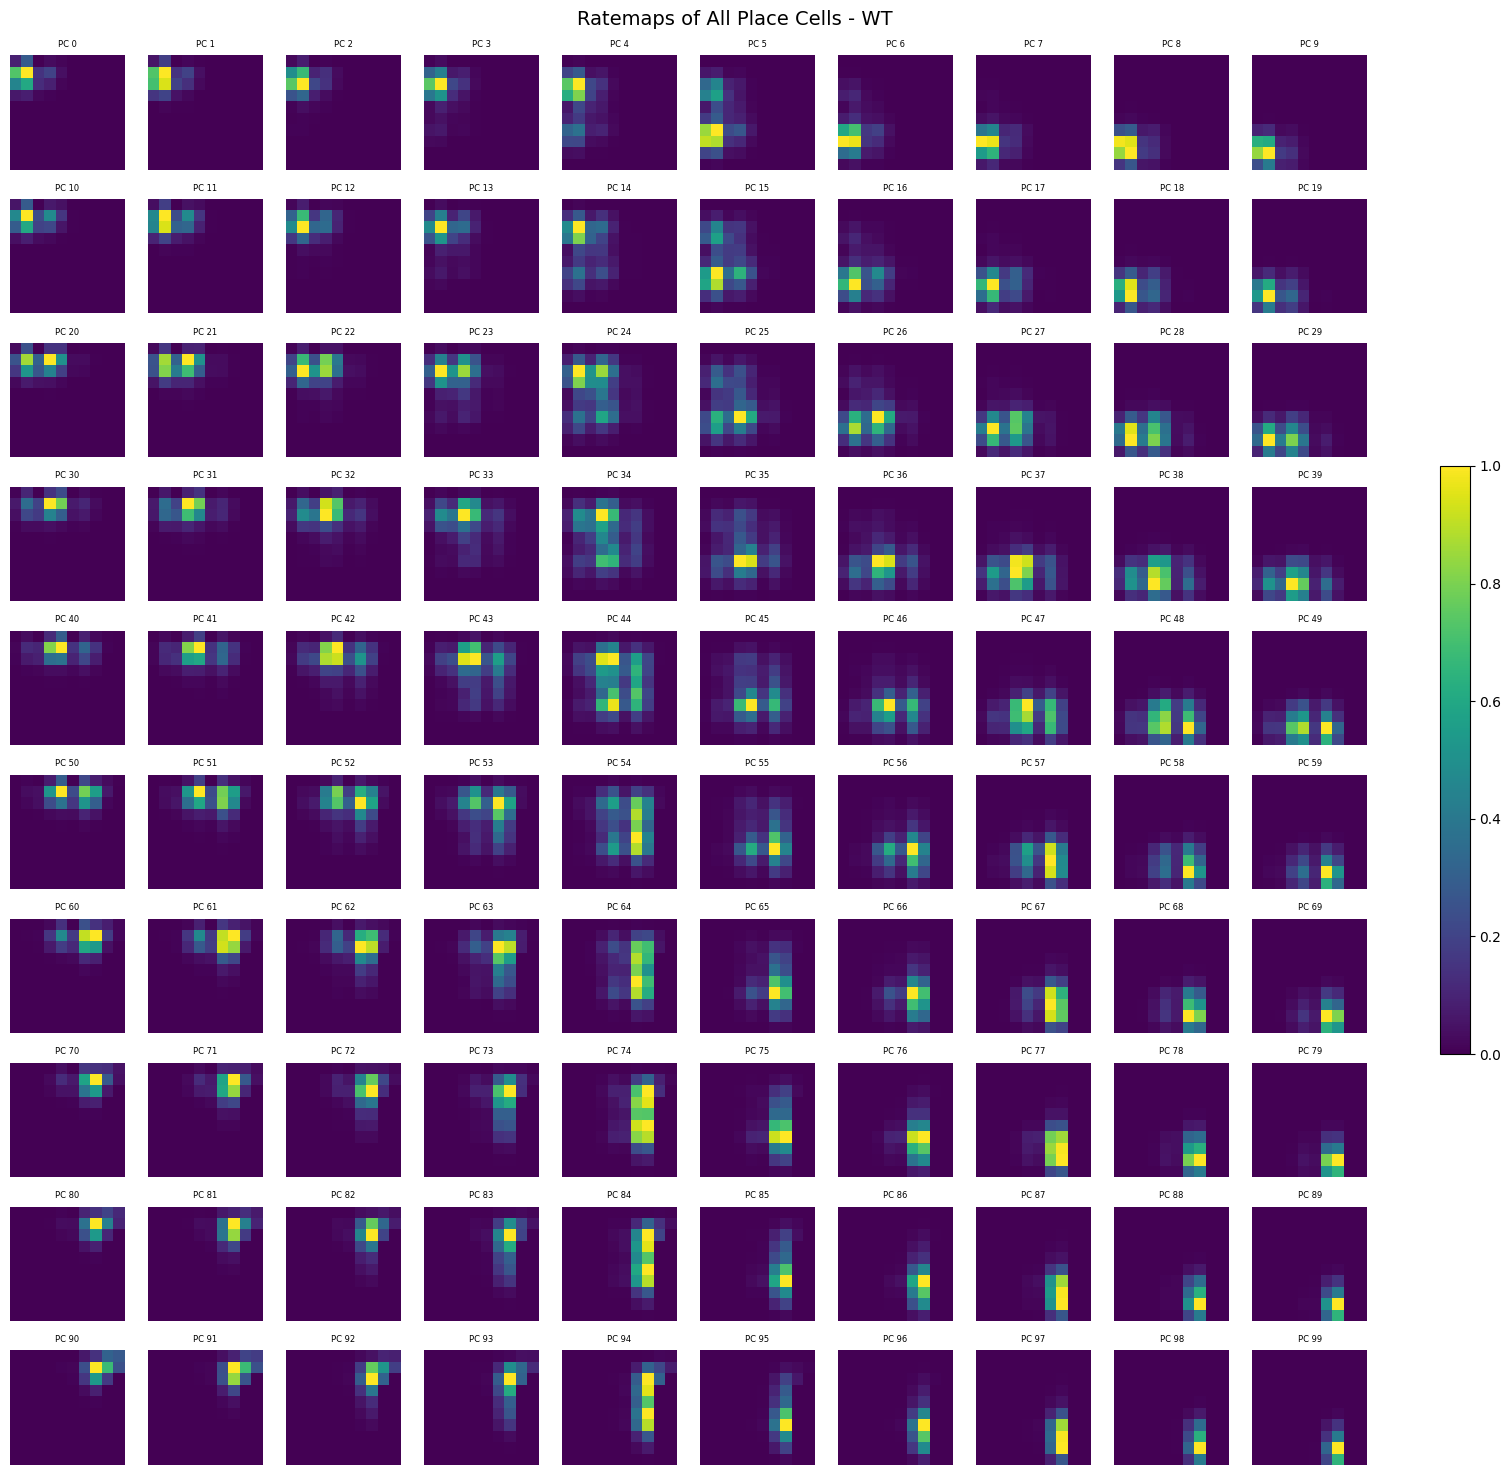


Running pipeline for Trajectory with 15% synaptic deletion
Completed pipeline for Trajectory with 15% synaptic deletion.


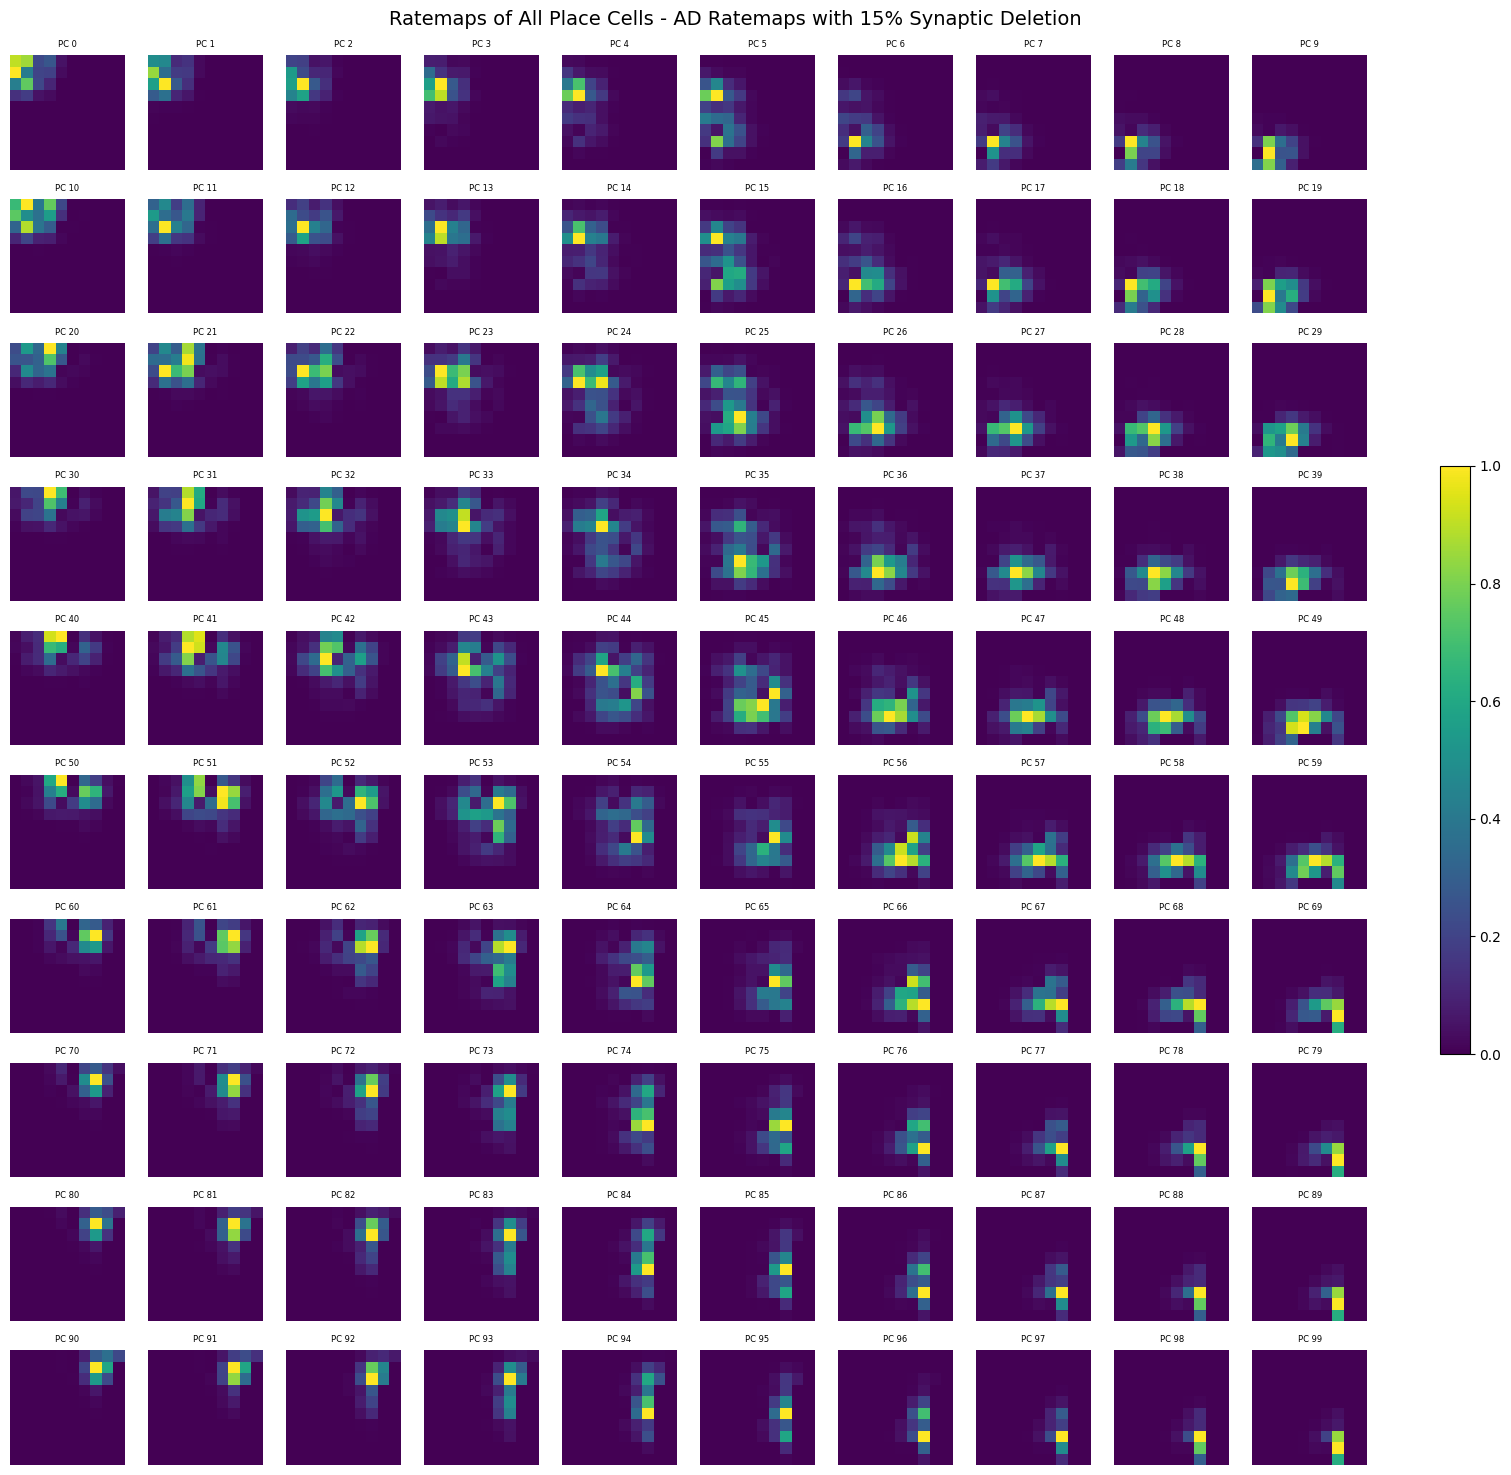

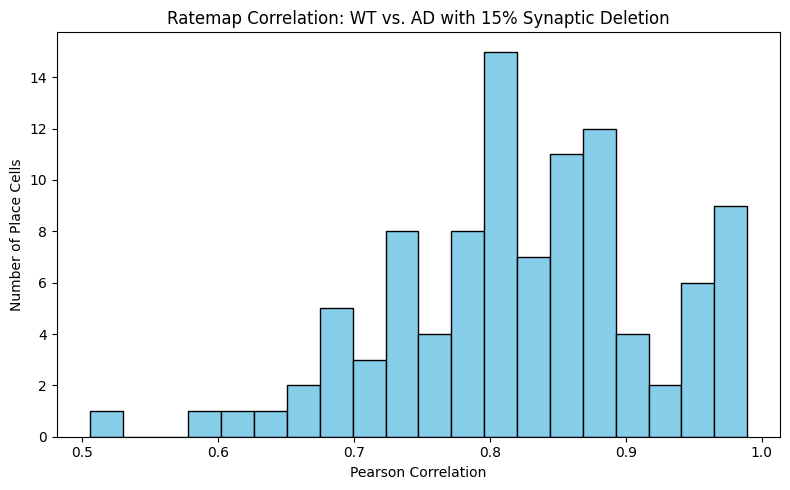

Mean correlation (excluding NaNs): 0.825


In [20]:
# Generate WT ratemaps
positions_WT = generate_trajectory(seed=42)
results_WT, ratemaps_WT = run_healthy_pipeline(positions_WT)
plot_all_ratemaps(ratemaps_WT, "Ratemaps of All Place Cells - WT")

# Generate AD ratemaps with Synaptic Deletion
positions_AD = generate_trajectory(seed=42)
results_AD, ratemaps_AD = run_AD_synaptic_deletion_pipeline(positions_AD, synaptic_deletion_percent=15)
plot_all_ratemaps(ratemaps_AD, "Ratemaps of All Place Cells - AD Ratemaps with 15% Synaptic Deletion")

# Calculate Pearson correlation per cell
from scipy.stats import pearsonr

correlations = []

for k in range(nCells):
    rm_WT = ratemaps_WT[k].flatten()
    rm_AD = ratemaps_AD[k].flatten()
    
    # Handle potential NaNs or zero variance cases
    if np.std(rm_WT) == 0 or np.std(rm_AD) == 0:
        corr = np.nan  # Cannot compute meaningful correlation
    else:
        corr, _ = pearsonr(rm_WT, rm_AD)
    
    correlations.append(corr)

correlations = np.array(correlations)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(correlations[~np.isnan(correlations)], bins=20, color='skyblue', edgecolor='k')
plt.xlabel("Pearson Correlation")
plt.ylabel("Number of Place Cells")
plt.title("Ratemap Correlation: WT vs. AD with 15% Synaptic Deletion")
plt.tight_layout()
plt.show()

# Print mean stability
print(f"Mean correlation (excluding NaNs): {np.nanmean(correlations):.3f}")

In [21]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Generate WT ratemap
positions_WT = generate_trajectory(seed=42)
results_WT, ratemaps_WT = run_healthy_pipeline(positions_WT)
pc = 45
rm_WT = ratemaps_WT[pc]

# Generate 15% synaptic deletion ratemap
positions_SD = generate_trajectory(seed=42)
results_SD, ratemaps_SD = run_AD_synaptic_deletion_pipeline(positions_SD, synaptic_deletion_percent=15)
rm_SD = ratemaps_SD[pc]

# Generate 15% neuronal deletion ratemap 
positions_CD = generate_trajectory(seed=42)
results_CD, ratemaps_CD = run_AD_cell_deletion_pipeline(positions_CD, cell_deletion_percent=15)
rm_CD = ratemaps_CD[pc]

# Generate Gaussian noise ratemap
positions_GN = generate_trajectory(seed=42)
results_GN, ratemaps_GN = run_AD_gaussian_noise_pipeline(positions_GN)
rm_GN = ratemaps_GN[pc]

# Calculate Pearson correlation with WT
def compute_corr(rm1, rm2):
    r1 = rm1.flatten()
    r2 = rm2.flatten()
    if np.std(r1) == 0 or np.std(r2) == 0:
        return np.nan
    else:
        corr, _ = pearsonr(r1, r2)
        return corr

corr_SD = compute_corr(rm_WT, rm_SD)
corr_CD = compute_corr(rm_WT, rm_CD)
corr_GN = compute_corr(rm_WT, rm_GN)

print(f"PC {pc} correlation with WT:")
print(f"- Synaptic Deletion (15%): {corr_SD:.3f}")
print(f"- Cell Deletion (15%): {corr_CD:.3f}")
print(f"- Gaussian Noise: {corr_GN:.3f}")

# Plot PC 45 ratemaps
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(np.flip(rm_WT, axis=0), cmap='viridis', origin='lower')
axs[0].set_title("WT")
axs[0].axis('off')

axs[1].imshow(np.flip(rm_SD, axis=0), cmap='viridis', origin='lower')
axs[1].set_title("15% Synaptic Deletion")
axs[1].axis('off')

axs[2].imshow(np.flip(rm_CD, axis=0), cmap='viridis', origin='lower')
axs[2].set_title("15% Cell Deletion")
axs[2].axis('off')

axs[3].imshow(np.flip(rm_GN, axis=0), cmap='viridis', origin='lower')
axs[3].set_title("Gaussian Noise")
axs[3].axis('off')

plt.suptitle(f"Ratemaps of PC {pc} under Different Conditions")
plt.tight_layout()
plt.show()


 Running pipeline for Trajectory
Completed pipeline for Trajectory.

Running pipeline for Trajectory with 15% synaptic deletion
Completed pipeline for Trajectory with 15% synaptic deletion.

Running pipeline for Trajectory with 15% cell deletion


KeyboardInterrupt: 


 Running pipeline for Trajectory
Completed pipeline for Trajectory.


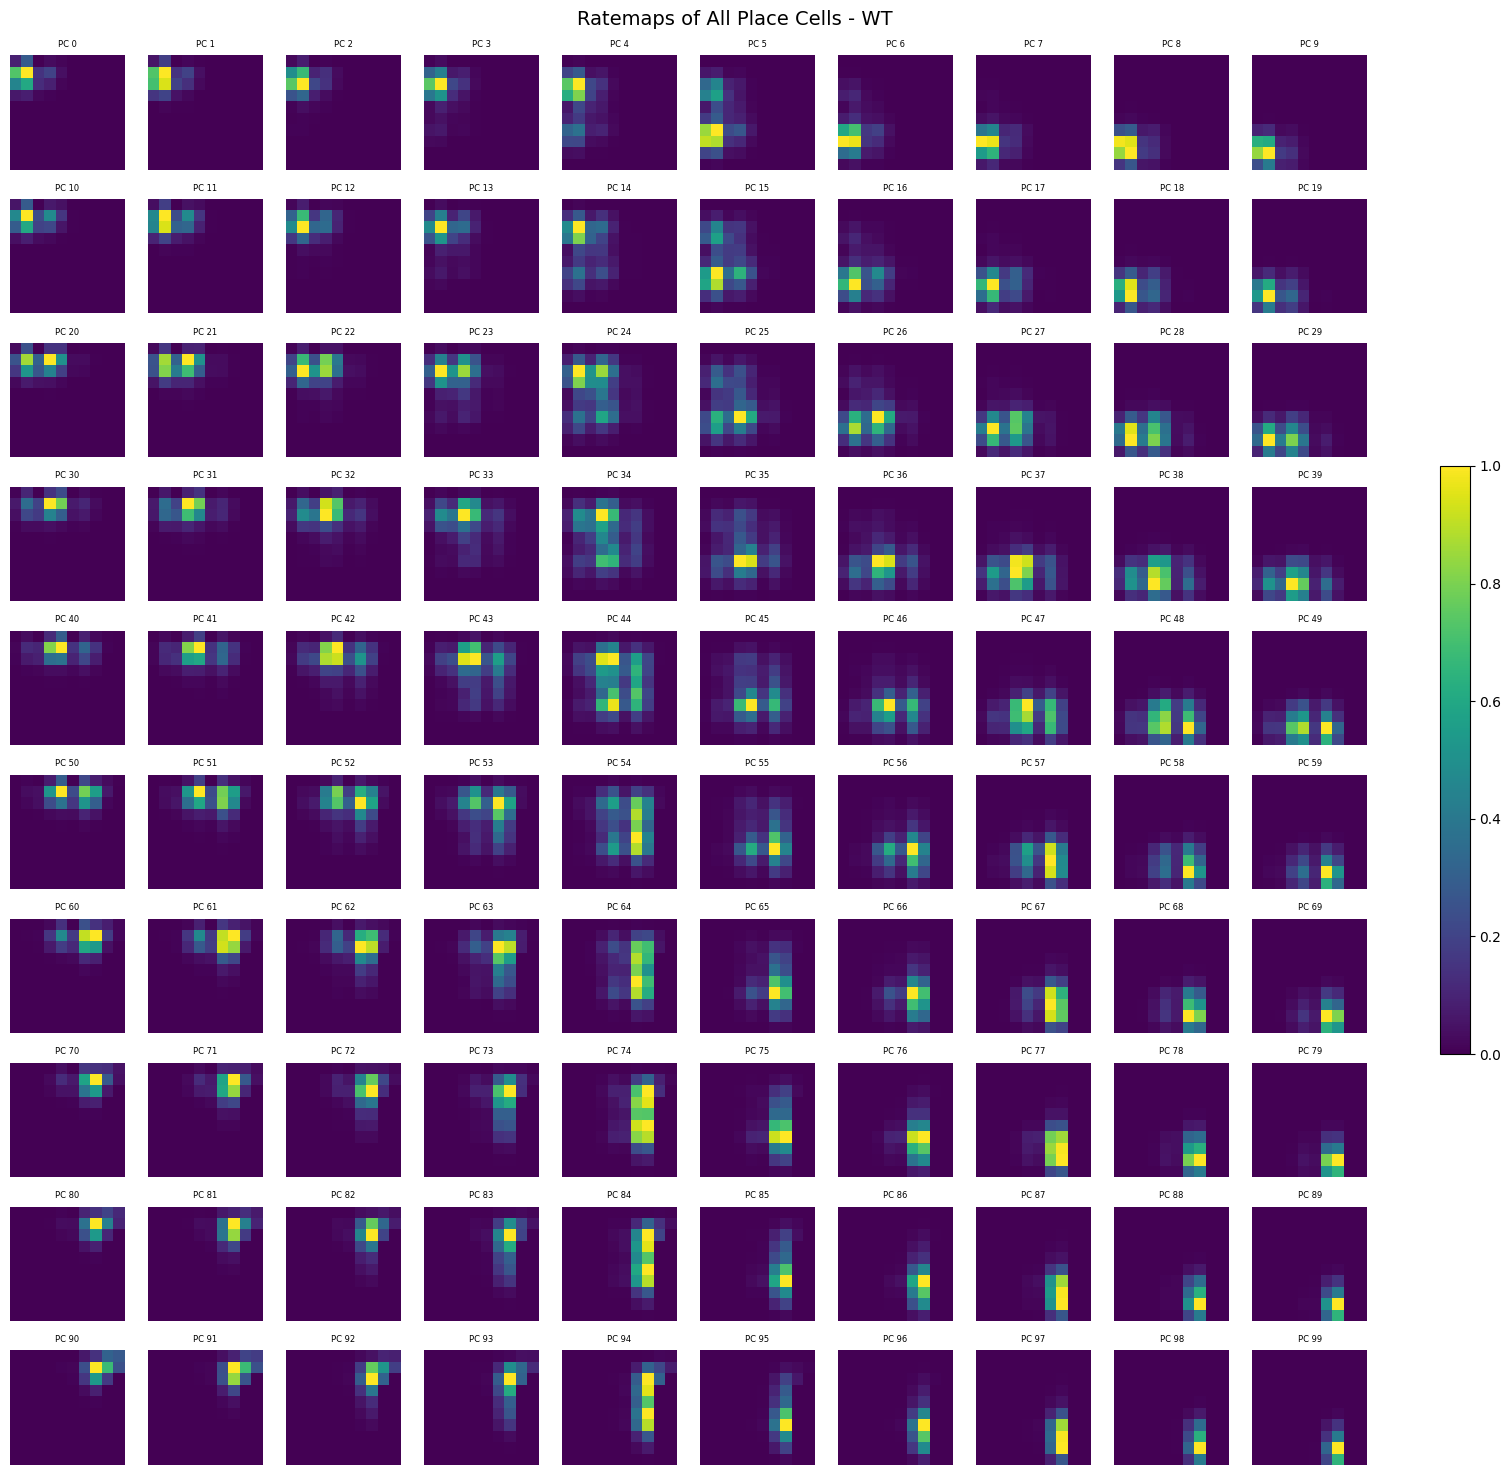


Running pipeline for Trajectory with 5% cell deletion
Completed pipeline for Trajectory with 5% cell deletion.


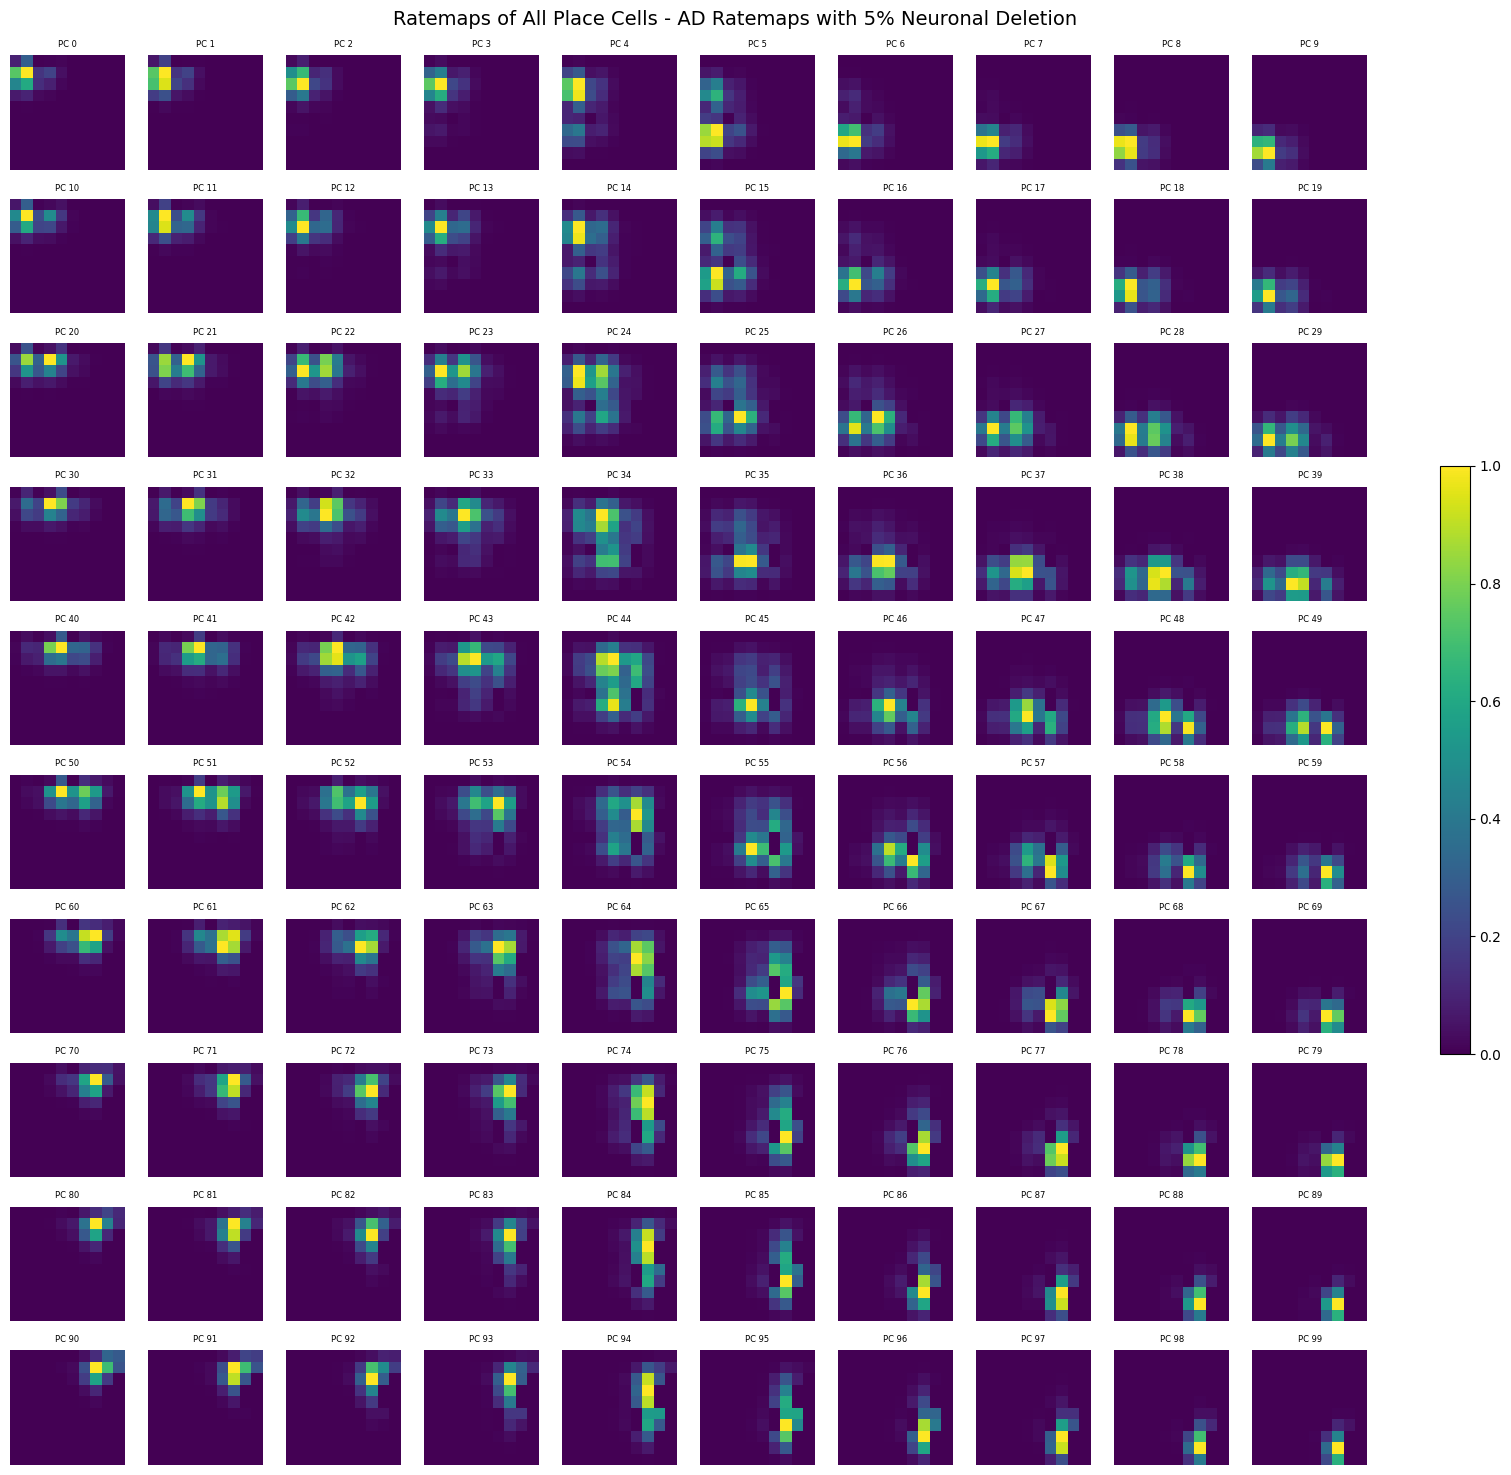

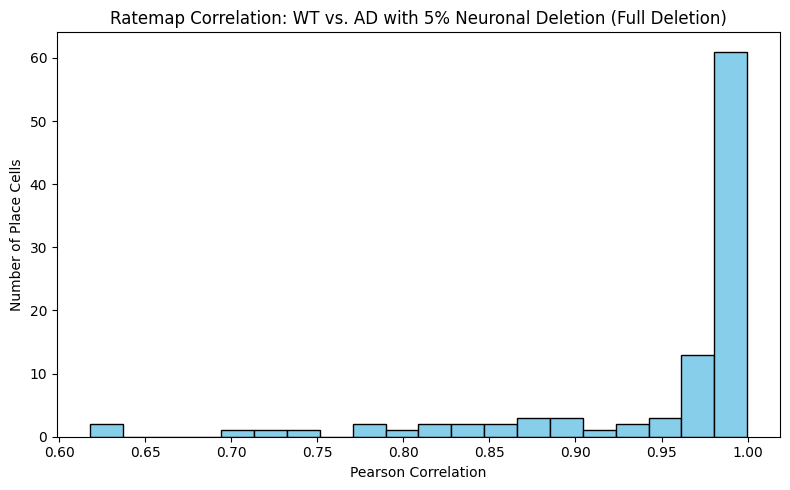

Mean correlation (excluding NaNs): 0.949


In [ ]:
# === Generate WT ratemaps ===
positions_WT = generate_trajectory(seed=42)
results_WT, ratemaps_WT = run_healthy_pipeline(positions_WT)
plot_all_ratemaps(ratemaps_WT, "Ratemaps of All Place Cells - WT")

# === Generate AD ratemaps with 15% Neuronal Deletion (full deletion version) ===
positions_AD = generate_trajectory(seed=42)
results_AD, ratemaps_AD = run_AD_cell_deletion_pipeline(positions_AD, cell_deletion_percent=5)
plot_all_ratemaps(ratemaps_AD, "Ratemaps of All Place Cells - AD Ratemaps with 5% Neuronal Deletion")

# === Calculate Pearson correlation per cell ===
from scipy.stats import pearsonr

correlations = []

for k in range(nCells):
    rm_WT = ratemaps_WT[k].flatten()
    rm_AD = ratemaps_AD[k].flatten()
    
    # Handle potential NaNs or zero variance cases
    if np.std(rm_WT) == 0 or np.std(rm_AD) == 0:
        corr = np.nan  # Cannot compute meaningful correlation
    else:
        corr, _ = pearsonr(rm_WT, rm_AD)
    
    correlations.append(corr)

correlations = np.array(correlations)

# === Plot histogram ===
plt.figure(figsize=(8, 5))
plt.hist(correlations[~np.isnan(correlations)], bins=20, color='skyblue', edgecolor='k')
plt.xlabel("Pearson Correlation")
plt.ylabel("Number of Place Cells")
plt.title("Ratemap Correlation: WT vs. AD with 5% Neuronal Deletion (Full Deletion)")
plt.tight_layout()
plt.show()

# === Print mean stability ===
print(f"Mean correlation (excluding NaNs): {np.nanmean(correlations):.3f}")

In [ ]:
#  Generate WT ratemaps
positions_WT = generate_trajectory(seed=42)
results_WT, ratemaps_WT = run_healthy_pipeline(positions_WT)
plot_all_ratemaps(ratemaps_WT, "Ratemaps of All Place Cells - WT")

# Generate AD Gaussian Noise ratemaps
positions_AD = generate_trajectory(seed=42)
results_AD, ratemaps_AD = run_AD_gaussian_noise_pipeline(positions_AD)
plot_all_ratemaps(ratemaps_AD, "Ratemaps of All Place Cells - AD Gaussian Noise")
